# Autogenerate PDDL String Diagrams

[String diagrams](https://arxiv.org/pdf/0908.3347v1.pdf) are a graphical language used to describe symmetric monoidal categories (SMCs) from category theory. They can be seen as mathematical rigorous expressions to describe processes and their dependencies. In this notebook, we use string diagrams to express the solutions to [Planning Domain Definition Language (PDDL)](https://www.cs.toronto.edu/~sheila/2542/s14/A1/introtopddl2.pdf) problems. More specifically, we seek to observe if the string diagram representation can elucidate interesting properties of robot manipulator program plans in a manufacturing work cell. This code uses the WiringDiagram [Catlab](https://epatters.github.io/Catlab.jl/latest/) Julia library to construct the string diagrams. In these examples, the objects are considered to be Boolean expressions and the arrows, or morphisms, are the PDDL actions.

In [1305]:
# SOFTWARE PRE-REQ
# 
# Julia 1.3.1
# Catlab 0.5.3
# Latex

using Catlab.WiringDiagrams
using Catlab.Doctrines
using Catlab

using Catlab.Graphics
import Catlab.Graphics: Graphviz

import TikzPictures
using Catlab.Graphics

In [1306]:
EXAMPLE = "blocksworld";  

# Process PDDL Files and PDDL solution
To run this notebook, you must provide the name of directory (in `examples/`) containing domain.pddl, problem.pddl, and solution.txt in the `EXAMPLE` variable (above), then run _all_ cells. The composed string diagram is shown as the output of the last cell. It can also be seen as an SVG in `smc.dot.svg`.

## About files
The `domain.pddl` and `problem.pddl` files must adhere to [PDDL specifications](http://users.cecs.anu.edu.au/~patrik/pddlman/writing.html) following the `:strips` requirement.

The `solution.txt` file should be a newline for each action with parameters provided by a PDDL planner of choice. An example is shown below:
```
move lochome locbox2
pick boxa locbox2 grippera
drop boxa locbox2 grippera
```

One possible way to obtain a PDDL solution is to run [PDDL4j](https://github.com/pellierd/pddl4j) solver, using

`java -jar pddl4j-3.8.jar -o gripper2.pddl -f gripper2-problem.pddl`

the following solution was found:
```
parsing domain file "gripper2.pddl" done successfully
parsing problem file "gripper2-problem.pddl" done successfully
java.lang.IllegalStateException: Instrumentation environment not initialised.

encoding problem done successfully (12 ops, 8 facts)
* starting A*
java.lang.IllegalStateException: Instrumentation environment not initialised.
java.lang.IllegalStateException: Instrumentation environment not initialised.
* A* succeeded

found plan as follows:

0: (      move lochome locbox1) [1]
1: (pick boxa locbox1 grippera) [1]
2: (      move locbox1 locbox2) [1]
3: (drop boxa locbox2 grippera) [1]

plan total cost: 4.00


time spent:       0.09 seconds parsing 
                  0.03 seconds encoding 
                  0.00 seconds searching
                  0.12 seconds total time

memory used:     -0.00 MBytes for problem representation
                 -0.00 MBytes for searching
                 -0.00 MBytes total
```

The variables substituted in the signatures of the actions can be used to compose a full solution expressed in string diagram form.

In [1307]:
# Grab domain, problem, and solution files
DOMAIN_FILEPATH = joinpath("..", "examples", EXAMPLE, "domain.pddl")
PROBLEM_FILEPATH = joinpath("..", "examples", EXAMPLE, "problem.pddl")
SOLUTION_FILEPATH = joinpath("..", "examples", EXAMPLE, "solution.txt")

"../examples/blocks_2/solution.txt"

## Parse PDDL Domain File 

An `domain.pddl` file describes the available actions and their pre- and post-conditions in the planning space. An example domain file is shown here:

```pddl
(define (domain gripper-strips)
   (:predicates (location ?l)
		(box ?b)
		(gripper ?g)
		(at-robby ?l)
		(at ?b ?l)
		(free ?g)
		(carry ?o ?g))

   (:action move
       :parameters  (?from ?to)
       :precondition (and  (location ?from) (location ?to) (at-robby ?from))
       :effect (and  (at-robby ?to)
		     (not (at-robby ?from))))

   (:action pick
       :parameters (?obj ?loc ?gripper)
       :precondition  (and  (box ?obj) (location ?loc) (gripper ?gripper)
			    (at ?obj ?loc) (at-robby ?loc) (free ?gripper))
       :effect (and (carry ?obj ?gripper)
		    (not (at ?obj ?loc)) 
		    (not (free ?gripper))))

   (:action drop
       :parameters  (?obj ?loc ?gripper)
       :precondition  (and  (box ?obj) (location ?loc) (gripper ?gripper)
			    (carry ?obj ?gripper) (at-robby ?loc))
       :effect (and (at ?obj ?loc)
		    (free ?gripper)
		    (not (carry ?obj ?gripper)))))
```

A regex may be used to parse the domain file; however, this is not what is used in this notebook.
```
\(define\s\(domain\s([\w,-]+)\)\n\s+\(:predicates\s\(([\w,-]+)\s\?([\w,-]+)\)(\n\s+\(([\w,-]+)(\s\?([\w,-]+))+\))+\)(\n+\s+\(:action\s[\w,-]+\n?\s+:parameters\s+\((\s?\?([\w,-]+))+\)\n\s+:precondition\s([\w\s-?() ]+)\n\s+:effect\s([\w\s-?() ]+)\))+
```

In [1308]:
# Adapted to Julia from https://github.com/pucrs-automated-planning/pddl-parser/blob/master/PDDL.py
using Printf
function scan_tokens(filename)
    file = open(filename) do f
        domain_file = read(f, String)
        stack = []
        list = []
        tokens = eachmatch(r"[()]|[\w\-?:]+", domain_file)
        for tt in tokens
            t = String(tt.match)
            if t == "(" 
                stack = push!(stack, list)
                list = []
            elseif t == ")"
                if length(stack) > 0
                    l = list
                    list = pop!(stack)
                    list = push!(list, l)
                else
                    println("Missing open parentheses!")
                    return []
                end
            else
                list = push!(list, t)
            end
        end
        if length(stack) > 0
            println("Missing closing parentheses!")
            return
        end
        if length(list) != 1
            println("Malformed expressed")
            return
        end
        return list[1]
    end
end

scan_tokens (generic function with 1 method)

In [1309]:
function parse_action(actions, group)
    name = splice!(group, 1)
    
    parameters = []
    pos_pre = []
    neg_pre = []
    add_post = []
    del_post = []
    
    while length(group) > 0
        t = splice!(group, 1)
        if t == ":parameters"
            parameters = []
            untyped_parameters = []
            p = splice!(group, 1)
            while length(p) > 0
                t = splice!(p, 1)
                untyped_parameters = push!(parameters, t)
            end
        elseif t == ":precondition"
            p = splice!(group, 1)
            pos_pre, neg_pre = split_predicates(p, pos_pre, neg_pre)
        elseif t == ":effect"
            p = splice!(group, 1)
            add_post, del_post = split_predicates(p, add_post, del_post)
        end
    end    
    a = Dict("name" => name,
             "parameters" => parameters, 
             "preconditions" => Dict("positive" => pos_pre, 
                                     "negative" => neg_pre),
             "postconditions" => Dict("positive" => add_post,
                                      "negative" => del_post))
    actions = push!(actions, a)
    return actions
end

parse_action (generic function with 1 method)

In [1310]:
function parse_predicates(predicates, group)
    for pred in group
        predicate_name = splice!(pred, 1)
        untyped_variables = []
        while length(pred) > 0
            t = splice!(pred, 1)
            untyped_variables = push!(untyped_variables, t)
        end
        predicates[predicate_name] = untyped_variables
    end
    return predicates
end

parse_predicates (generic function with 1 method)

In [1311]:
function split_predicates(group, pos, neg)
    if group[1] == "and"
        group = deleteat!(group, 1)
    else
        group = [group]
    end
    for predicate in group
        if length(predicate) < 1
            return [], []
        end
        if predicate[1] == "not"
            neg = append!(neg, predicate[end])
        else
            pos = append!(pos, predicate)
        end
    end
    return pos, neg
end

split_predicates (generic function with 1 method)

In [1312]:
using JSON
function parse_domain(domain_filename)
    tokens = scan_tokens(domain_filename)
    if (tokens == nothing) 
        return Dict("name" => "", 
        "predicates" => Dict(), 
        "actions" => Dict())
    end
    splice!(tokens, 1)
    domain_name = "unknown"
    actions = []
    predicates = Dict()
    while length(tokens)>0
        group = splice!(tokens, 1)
        t = splice!(group, 1)
        if t == "domain"
            domain_name = group[1]
        elseif t == ":predicates"
            predicates = parse_predicates(predicates, group)
        elseif t == ":action"
            actions = parse_action(actions, group)
        end
    end
    domain = Dict("name" => domain_name, 
        "predicates" => predicates, 
        "actions" => actions)
    return domain
end

domain = parse_domain(DOMAIN_FILEPATH)
# print(json(domain,4))

Dict{String,Any} with 3 entries:
  "name"       => "BLOCKS"
  "actions"    => Any[Dict{String,Any}("name"=>"pick-up","parameters"=>Any["?x"…
  "predicates" => Dict{Any,Any}("holding"=>Any["?x"],"handempty"=>Any[],"on"=>A…

## Use Catlab to make objects and morphisms for PDDL domain

In [1313]:
function make_objects(predicates)
    port_map = Dict()
    for (name, variables) in predicates
        port_name = name
        for v in variables
            port_name = port_name * "\t" * v
        end
        port_map[name] = Ob(FreeSymmetricMonoidalCategory, port_name)
    end
    return port_map
end
port_map = make_objects(domain["predicates"])

Dict{Any,Any} with 5 entries:
  "holding"   => holding	?x
  "handempty" => handempty
  "on"        => on	?x	?y
  "ontable"   => ontable	?x
  "clear"     => clear	?x

In [1314]:
function make_neg_objects(predicates)
    port_map = Dict()
    for (name, variables) in predicates
        port_name = "&not;\t" * name
        for v in variables
            port_name = port_name * "\t" * v
        end
        port_map[name] = Ob(FreeSymmetricMonoidalCategory, port_name)
    end
    return port_map
end
neg_port_map = make_neg_objects(domain["predicates"])

Dict{Any,Any} with 5 entries:
  "holding"   => &not;	holding	?x
  "handempty" => &not;	handempty
  "on"        => &not;	on	?x	?y
  "ontable"   => &not;	ontable	?x
  "clear"     => &not;	clear	?x

### Generate Homomorphisms in Free Symmetric Monoidal Category
```
pick_smt = Hom(:pick, 
        box_boxA⊗location_locBox1⊗gripper_gripperA⊗at_boxA_locBox1⊗at_robby_locBox1⊗free_gripperA, 
        carry_boxA_gripperA⊗not_at_boxA_locBox1⊗not_free_gripperA)
```

In [1315]:
function otimes_ports(conditions, port_map, neg_port_map)
    counter = 1
    
    pos_conditions = conditions["positive"]
    neg_conditions = conditions["negative"]
    
    for c in pos_conditions
        if !occursin("?", c)
            if counter == 1
                global ports = port_map[c]  # shouldn't need to be global
                counter += 1
            else
                global ports = otimes(ports, port_map[c])
            end
        end
    end
    
    for c in neg_conditions
        if !occursin("?", c)
            if counter == 1
                global ports = port_map[c]  # shouldn't need to be global
                counter += 1
            else
                global ports = otimes(ports, neg_port_map[c])
            end
        end
    end
    
    return ports
end

function make_morphisms(actions, port_map, neg_port_map)
    action_map = Dict()
    for act in actions
        name = act["name"]
        
        preconditions = act["preconditions"]
        postconditions = act["postconditions"]

        inputs = otimes_ports(preconditions, port_map, neg_port_map)
        outputs = otimes_ports(postconditions, port_map, neg_port_map)
        
        action_map[name] = Hom(name, inputs, outputs)
    end
    return action_map
end

morphism_map = make_morphisms(domain["actions"], port_map, neg_port_map)

Dict{Any,Any} with 4 entries:
  "put-down" => put-down
  "unstack"  => unstack
  "stack"    => stack
  "pick-up"  => pick-up

In [1316]:
function draw_morphisms(morphism_map, prefix, b_labels)
    for k in keys(morphism_map)
        graph = to_graphviz(morphism_map[k]; labels=b_labels)
        filename = joinpath(@__DIR__, "morphisms", prefix * k * ".dot.svg")
        open(filename, "w") do fp 
            print(fp, Graphviz.run_graphviz(graph, format="svg")) 
        end
        open(filename) do f
           display("image/svg+xml", read(f, String))
        end
    end
end

draw_morphisms (generic function with 1 method)

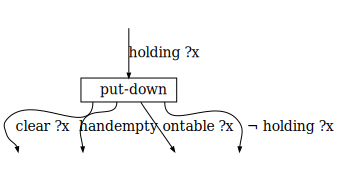

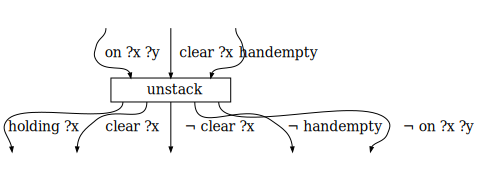

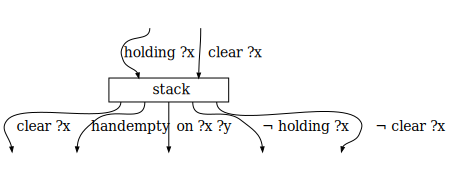

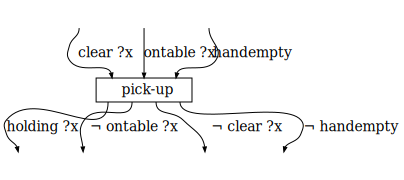

In [1317]:
draw_morphisms(morphism_map, "domain_", true)

## Parse PDDL Problem File

The problem file describes the initial (`:init`) and goal (`:goal`) state of a given task in terms of conditions, or "predicates". An example is shown here:

```
 (define (problem strips-gripper2)
   (:domain gripper-strips)
   (:objects locHome locBox1 locBox2 boxA gripperA)
   (:init (location locHome)
          (location locBox1)
          (location locBox2)
          (box boxA)
          (gripper gripperA)
          (at-robby locHome)
          (free gripperA)
          (at boxA locBox1))
   (:goal (and (at boxA locBox2) (free gripperA) (location locHome))))
```

In [1318]:
using JSON

function parse_problem(problem_filename)
    tokens = scan_tokens(problem_filename)

    splice!(tokens, 1)  # remove "define" token
    
    problem_name = "unknown"
    domain_name = "unknown"
    object_list = []
    init = []
    pos_goal = []
    neg_goal = []
    
    while length(tokens)>0
        group = splice!(tokens, 1)
        t = splice!(group, 1)
        if t == "problem"
            problem_name = group[1]
        elseif t == ":domain"
            domain_name = group[1]
        elseif t == ":objects"
            splice!(group, 1)
            while length(group)>0
                if group[1] == "-"
                    splice!(group, 1)
                    objects[splice!(group, 1)] = object_list
                else
                    push!(object_list, splice!(group, 1))
                end
            end
        elseif t == ":init"  # FIXME: not being found
            while length(group)>0
                state = splice!(group, 1)
                append!(init, state)
            end
        elseif t == ":goal"
            p = splice!(group, 1)
            pos_goal_split, neg_goal_split = split_predicates(p, pos_goal, neg_goal)
            
            if length(pos_goal) > 1
                splice!(pos_goal_split, 1)
            end
            
            if length(neg_goal) > 1
                splice!(neg_goal_split, 1)
            end
            
            # make array of array --> array             
            pos_goal = []
            neg_goal = []
            
            for p in pos_goal_split
                append!(pos_goal, p)
            end
            
            for p in neg_goal_split
                append!(neg_goal, p)
            end
        end
    end
    problem = Dict("problem" => problem_name,
                   "domain" => domain_name,
                   "objects" => object_list,
                   "init" => init,
                   "goal" => Dict("positive" => pos_goal,
                                  "negative" => neg_goal))
    return problem
end

problem = parse_problem(PROBLEM_FILEPATH)
print(json(problem,4))

{
    "init": [
        "clear",
        "c",
        "clear",
        "a",
        "clear",
        "b",
        "ontable",
        "c",
        "ontable",
        "a",
        "ontable",
        "b",
        "handempty"
    ],
    "problem": "BLOCKS-3-0",
    "domain": "BLOCKS",
    "objects": [
        "b",
        "c"
    ],
    "goal": {
        "negative": [],
        "positive": [
            "on",
            "c",
            "b",
            "on",
            "b",
            "a"
        ]
    }
}


## Parse PDDL Solution

The PDDL solution is the sequence of actions prescribed by a PDDL solver. The [PDDL4J](http://pddl4j.imag.fr/index.html) solver was used offline to produce the `solution.txt` files. An example is shown here:

```
move lochome locbox1
pick boxa locbox1 grippera
move locbox1 locbox2
drop boxa locbox2 grippera
```

In [1319]:
function group_predicates(tokens, domain_pred)
    predicates = []
    pred = Dict()
    predicate_name = "unknown"
    untyped_variables = []
    while length(tokens)>0
        t = splice!(tokens, 1)
        if !(t in keys(domain_pred))
            push!(untyped_variables, t)
        else
            push!(predicates, pred)
            predicate_name = t
            untyped_variables = []
            pred = Dict()
        end
        pred[predicate_name] = untyped_variables
    end
    push!(predicates, pred)
    splice!(predicates, 1)
    return predicates
end
# action = domain["actions"][1]
# domain_pred = domain["predicates"]
# group_predicates(copy(action["preconditions"]["positive"]), domain_pred)
predicates = group_predicates(copy(problem["init"]), domain_pred)

7-element Array{Any,1}:
 Dict{Any,Any}("clear" => Any["c"])  
 Dict{Any,Any}("clear" => Any["a"])  
 Dict{Any,Any}("clear" => Any["b"])  
 Dict{Any,Any}("ontable" => Any["c"])
 Dict{Any,Any}("ontable" => Any["a"])
 Dict{Any,Any}("ontable" => Any["b"])
 Dict{Any,Any}("handempty" => Any[]) 

pick-up b
Base.RegexMatchIterator(r"[\w\-?]+\w?", "pick-up b", false)
["pick-up", "b"]
stack b a
Base.RegexMatchIterator(r"[\w\-?]+\w?", "stack b a", false)
["stack", "b", "a"]
pick-up c
Base.RegexMatchIterator(r"[\w\-?]+\w?", "pick-up c", false)
["pick-up", "c"]
stack c b
Base.RegexMatchIterator(r"[\w\-?]+\w?", "stack c b", false)
["stack", "c", "b"]


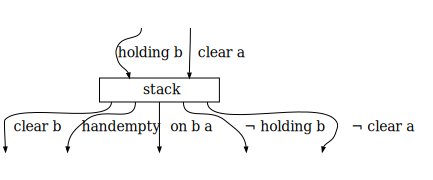

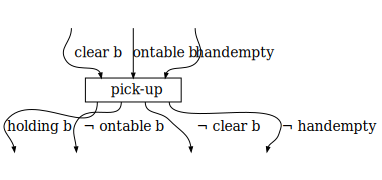

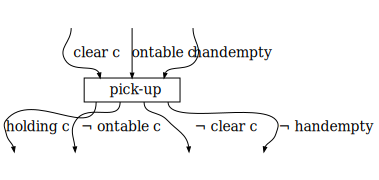

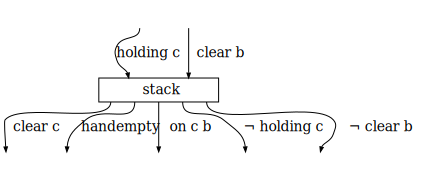

In [1320]:
function parse_solution(pddl_solution_filename, actions, domain_pred)
    count = 0
    pred = Dict()
    morphisms = Dict()
    for line in readlines(pddl_solution_filename)
        wordsr = eachmatch(r"[\w\-?]+\w?", line)
        words = map((x) -> String(x.match), wordsr)
        
        println(line)
        println(wordsr)
        println(words)
        
        action_sol = splice!(words, 1)
        var_sol = words
        
        action = filter((x) -> x["name"]==action_sol, actions)[1]
        action_name = action["name"]
        var_map = Dict(zip(action["parameters"], var_sol))
        
        grouped_pred = Dict("action" => action_name, "preconditions" => Dict(), "postconditions" => Dict())
        grouped_pred["preconditions"]["positive"] = group_predicates(copy(action["preconditions"]["positive"]), domain_pred)
        grouped_pred["preconditions"]["negative"] = group_predicates(copy(action["preconditions"]["negative"]), domain_pred)
        grouped_pred["postconditions"]["positive"] = group_predicates(copy(action["postconditions"]["positive"]), domain_pred)
        grouped_pred["postconditions"]["negative"] = group_predicates(copy(action["postconditions"]["negative"]), domain_pred)
            
        for cond in ["preconditions", "postconditions"]
            b_first_port = true
            v0 = grouped_pred[cond]
            for sign in ["positive", "negative"]
                v1 = v0[sign]
                for p_dict in v1
                    for (var, assgn) in var_map
                        map((x) -> replace!(x, var => assgn), values(p_dict))
                    end
                    
                    if sign == "positive"
                        new_port = make_objects(p_dict)
                    elseif sign == "negative"
                        new_port = make_neg_objects(p_dict)
                    end
  
                    for (name, port) in new_port
                        if b_first_port
                            global ports = port
                            b_first_port = false
                        else
                            global ports = otimes(ports, port)
                        end
                    end
         
                end
            end
            if cond == "preconditions"
                global inputs = ports
            elseif cond == "postconditions"
                global outputs = ports
            end
        end
        pred[string(count)] = grouped_pred
        morphisms[string(count)] = Hom(action_name, inputs, outputs)
        count += 1
    end
    return pred, morphisms
end

domain = parse_domain(DOMAIN_FILEPATH)
solution_predicates, solution_morphisms = parse_solution(SOLUTION_FILEPATH, domain["actions"], domain["predicates"])
draw_morphisms(solution_morphisms, "solution_", true)
# print(json(solution_morphisms,4)) 

## Build String Diagram

After the sequence of actions have been converted into morphisms, we must chain, or "compose" these morphisms to generate a fully connected diagram. A naive chaining algorithm has been implemented to determine valid tensor products and compositions, according to category theoretic properties. Catlab enforces the compatibility of domains and co-domains of morphisms during composition. 

In this algorithm, there exists a notion of "blocks" where each block is a list that contains the morphisms (identity, braids, and homomorphisms). The order of the list corresponds to the order that the morphisms will be tensored. Blocks are collected in their entirety before they are tensored and composed together.

There are four main steps to the algorithm:
1. *Backward pass* to weave input strings of each morphism, from goal state to initial state (bottom-up)
2. *Forward pass* to weave output strings of each morphism, from initial state to goal state (top-down)
3. *Add braids* to add braids, or swaps, in case the order of the tensor product is not compatible for composition
4. *Compose* to chain the blocks from top-down. This constructs the string diagram.

In [1321]:
function make_all_strings(block, interface)
    if interface == "input"
        f = 2
    elseif interface == "output"
        f = 3
    else
        f = nothing
    end
    
    new_block = []
    for m in block
        if typeof(m) == Catlab.Doctrines.FreeSymmetricMonoidalCategory.Hom{:generator}
            try
                for s in m.args[f].args  # input arguments of morphism
                    push!(new_block, id(s))
                end
            catch
                s = m.args[f]
                push!(new_block, id(s))
            end
        elseif typeof(m) == Catlab.Doctrines.FreeSymmetricMonoidalCategory.Hom{:id} 
            push!(new_block, m)
        elseif typeof(m) == Catlab.Doctrines.FreeSymmetricMonoidalCategory.Hom{:braid}
            for s in m.type_args[f-1].args
                push!(new_block, id(s))
            end
        end
    end
    return new_block
end

make_all_strings (generic function with 1 method)

In [1322]:
function otimes_strings(strings)
    b_first_port = true
    for p in strings
        if b_first_port
            global ports = p
            b_first_port = false
        else
            global ports = otimes(ports, p)
        end
    end
    return ports
end

otimes_strings (generic function with 1 method)

In [1323]:
# import Catlab.Graphics: TikZ

# To convert SVG to PDF or Latex: inkscape --export-type=pdf smc.dot.svg
# Note: inkscape MUST be installed (brew cask install inkscape)

function draw_string_diagram(smc, name, b_labels)
    graph = to_graphviz(smc; labels=b_labels)
#     tikz_doc = to_tikz(smc; labels=b_labels)
#     TikZ.pprint(tikz_doc)
    filename = joinpath(@__DIR__, name * ".dot.svg")
    open(filename, "w") do fp 
        print(fp, Graphviz.run_graphviz(graph, format="svg")) 
    end
    open(filename) do f
       display("image/svg+xml", read(f, String))
    end
end

draw_string_diagram (generic function with 1 method)

In [1324]:
function bubble_sort_tracking(ls)
    transforms = []
    swaps_exist = true
    while swaps_exist
        swaps_exist = false
        for (i, el) in enumerate(ls)
            if (i + 1 <= length(ls))
                if el < ls[i+1]
                    continue
                elseif el > ls[i+1]
                    push!(transforms, (i, i+1))
                    swaps_exist = true
                    
                    fst = el
                    snd = ls[i+1]
                    ls[i] = snd
                    ls[i+1] = fst
                end
            end
        end
    end
    return transforms
end

bubble_sort_tracking (generic function with 1 method)

In [1333]:
function make_problem_blocks(problem, domain_pred)
    # Convert initial and goal state to list of identity morphisms
    
    # Make Initial State Block
    init_pred = group_predicates(copy(problem["init"]), domain_pred)
    init_obj = []
    for p in init_pred
        obj = make_objects(p)
        push!(init_obj, obj)
    end
    init = []
    for o in init_obj
        obj = collect(values(o))[1] # collect returns an array of values
        push!(init, id(obj))
    end
    
    # Make Goal State Block
    grouped_pos = group_predicates(copy(problem["goal"]["positive"]), domain_pred)
    goal_obj = []
    for p in grouped_pos
        obj = make_objects(p)
        push!(goal_obj, obj)
    end
    
    grouped_neg = group_predicates(copy(problem["goal"]["negative"]), domain_pred)
    for p in grouped_neg
        obj = make_objects(p)
        push!(goal_obj, obj)
    end

    goal = []
#     for o in goal_obj
#         obj = collect(values(o))[1] # collect returns an array of values
#         push!(goal, id(obj))
#     end
    
    return init, goal
    
end

init, goal = make_problem_blocks(problem, domain["predicates"])

(Any[id(clear	c), id(clear	a), id(clear	b), id(ontable	c), id(ontable	a), id(ontable	b), id(handempty)], Any[])

stack
pick-up
stack
pick-up
Any[id(clear	c), id(clear	a), id(clear	b), id(ontable	c), id(ontable	a), id(ontable	b), id(handempty)]
Any[id(clear	c), id(clear	a), id(clear	b), id(ontable	c), id(ontable	a), id(ontable	b), id(handempty)]


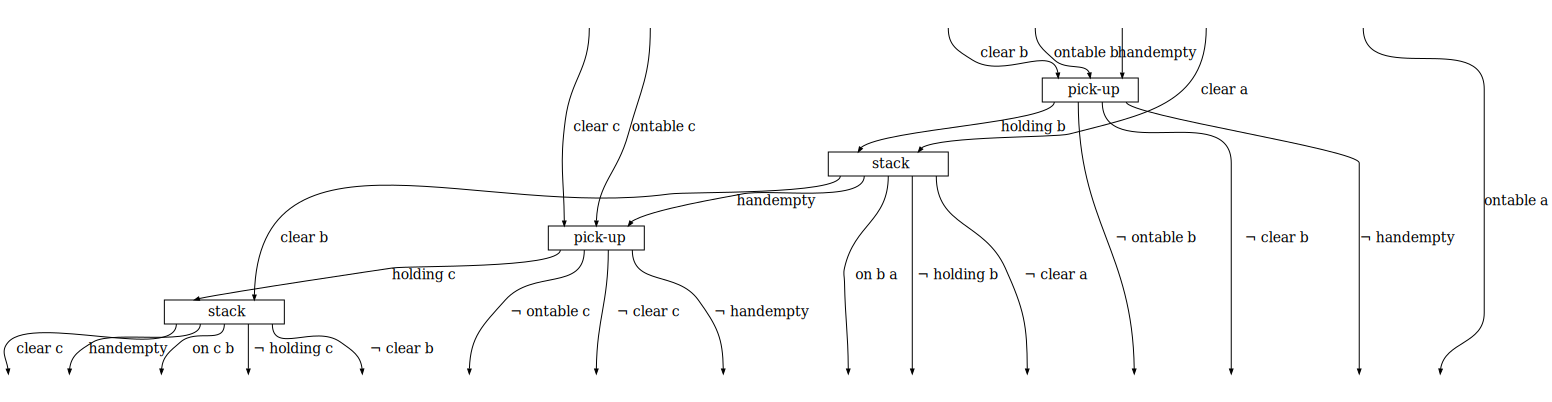

compose(otimes(id(clear	c),id(ontable	c),id(clear	b),id(ontable	b),id(handempty),id(clear	a),id(ontable	a)),otimes(id(clear	c),id(ontable	c),id(clear	b),id(ontable	b),id(handempty),id(clear	a),id(ontable	a)),otimes(id(clear	c),id(ontable	c),pick-up,id(clear	a),id(ontable	a)),otimes(id(clear	c),id(ontable	c),id(holding	b),id(&not;	ontable	b),id(&not;	clear	b),braid(&not;	handempty,clear	a),id(ontable	a)),otimes(id(clear	c),id(ontable	c),id(holding	b),id(&not;	ontable	b),braid(&not;	clear	b,clear	a),id(&not;	handempty),id(ontable	a)),otimes(id(clear	c),id(ontable	c),id(holding	b),braid(&not;	ontable	b,clear	a),id(&not;	clear	b),id(&not;	handempty),id(ontable	a)),otimes(id(clear	c),id(ontable	c),stack,id(&not;	ontable	b),id(&not;	clear	b),id(&not;	handempty),id(ontable	a)),otimes(id(clear	c),id(ontable	c),braid(clear	b,handempty),id(on	b	a),id(&not;	holding	b),id(&not;	clear	a),id(&not;	ontable	b),id(&not;	clear	b),id(&not;	handempty),id(ontable	a)),otimes(pick-up,id(clear	b),id(on	b	a),i

In [1341]:
function backward_pass(curr_block, above_morph)
    above_block = []
    
    if typeof(above_morph) == Catlab.Doctrines.FreeSymmetricMonoidalCategory.Hom{:generator}
        above_strings = make_all_strings([above_morph], "output")
        above_output = above_morph.args[3]
    else
        above_strings = above_morph
        above_output = nothing
    end
    
    println(above_morph)
    
    morph_added = false
    for m in curr_block
        if typeof(m) == Catlab.Doctrines.FreeSymmetricMonoidalCategory.Hom{:generator}  # if generator morphism
            try
                for s in m.args[2].args  # for input arguments of morphism
                    if (above_output != nothing) && (id(s) in above_strings) && (!morph_added)  # if input arg in output of above
                        push!(above_block, above_morph)
                        morph_added = true
                        
                        deleteat!(above_strings, findfirst(x->x==id(s), above_strings)) # update strings accounted for in above strings
                    else
                        push!(above_block, id(s))
                    end
                end
            catch
                s = m.args[2]
                if (above_output != nothing) && (id(s) in above_strings) && (!morph_added)  # if input arg in output of above
                    push!(above_block, above_morph)
                    morph_added = true
                else
                    push!(above_block, id(s))
                end
            end
        elseif typeof(m) == Catlab.Doctrines.FreeSymmetricMonoidalCategory.Hom{:id}  # if identity morphism
            if !(m in above_strings)
                push!(above_block, m)
            else
                if (above_output != nothing) # if above morph is a generator, do not push because it will be handled with morph
                    deleteat!(above_strings, findfirst(x->x==m, above_strings))
                else
                    push!(above_block, m) # if above morph is not a generator, push string, no "hidden" strings
                end
            end
        end
    end
    
    if (!morph_added) && (above_output != nothing)
        push!(above_block, above_morph)
    end
    
    return above_block    
end

function forward_pass(curr_block, below_block)
    
    below_strings = make_all_strings(below_block, "input")
    
    morph_added = false
    for m in curr_block
        if typeof(m) == Catlab.Doctrines.FreeSymmetricMonoidalCategory.Hom{:generator}  # if generator morphism
            try
                for s in m.args[3].args
                    if !(id(s) in below_strings)
                        push!(below_block, id(s))
                    else
                        deleteat!(below_strings, findfirst(x->x==id(s), below_strings))
                    end
                end
            catch
                s = m.args[3]
                if !(id(s) in below_strings)
                        push!(below_block, id(s))
                    else
                        deleteat!(below_strings, findfirst(x->x==id(s), below_strings))
                    end
            end
        elseif typeof(m) == Catlab.Doctrines.FreeSymmetricMonoidalCategory.Hom{:id}  # if identity morphism
            if !(m in below_strings)
                push!(below_block, m)
            else
                deleteat!(below_strings, findfirst(x->x==m, below_strings))
            end
        end
    end
    
end

function bubble_sort_braiding(perm, block)
    blocks = [block]
    
    swaps_exist = true
    while swaps_exist # keep checking for swaps in the current permutation
        swaps_exist = false
        val = make_all_strings(block, "output")
        
        block = []
        skip = -1
        for (i, el) in enumerate(perm) # do one pass through list of permutations
            if (i+1 <= length(perm))
                if i == skip
                    continue
                elseif el < perm[i+1] || swaps_exist # if the current number is less than the adjacent number
                    push!(block, val[i]) # leave value in current position
                elseif el > perm[i+1] # if the current number is greater than the adjacent number
                    swaps_exist = true

                    fst = el        # larger no.
                    snd = perm[i+1] # smaller no.

                    # swap in permutation list
                    perm[i] = snd
                    perm[i+1] = fst

                    # braid and append to result
                    push!(block, braid(val[i].args[1], val[i+1].args[1]))
                    
                    skip = i+1
                end
            elseif i != skip
                push!(block, val[i])
            end
        end
        if swaps_exist == true
            push!(blocks, block)
        end
        
    end
    
    return blocks
end

function add_braids(blocks)
    new_blocks = [] # first block stays the same
    
    for i in 1:length(blocks)-1 # start with the first element of blocks, so previous block can be checked
        curr_block = blocks[i]
        next_block = blocks[i+1]
        
        curr_str = make_all_strings(curr_block, "output")
        next_str = make_all_strings(next_block, "input")
        
        curr_str_perm = []
        
        # For every string in block, find index of matching string in previous block
        for s in curr_str 
            check_ind = 1
            while (check_ind <= length(next_str)  # if there are more strings in the next block to check
                && next_str[check_ind] != s      # if previous string at index doesn't equal current string
                || (check_ind in curr_str_perm))  # if index corresponding to next block was already added
                
                check_ind = check_ind + 1 # increment index to check in previous block
            end
            push!(curr_str_perm, check_ind) # add position of current string in previous block
        end
        
        # track bubble sort for each permutation
        braided_blocks = bubble_sort_braiding(curr_str_perm, curr_block)
        new_blocks = vcat(new_blocks, braided_blocks)
    end
    
    return new_blocks
end

function build_string_diagram(morphisms, problem, domain, b_compose_diagram::Bool)
    n_steps = length(keys(morphisms))-1 # number of steps in PDDL solution
    init, goal = make_problem_blocks(problem, domain["predicates"]) # convert initial and goal state of PDDL to blocks
    
    last_morphism = morphisms[string(n_steps)] # last step in PDDL solution
    
    # Backward pass (weaving input strings from bottom to top)  
    curr_block = goal
    blocks = [curr_block] # instantiate blocks with goal block
    for i in n_steps:-1:-2
        if i < 0
            above_morph = init
        else
            above_morph = morphisms[string(i)]
        end
        curr_block = backward_pass(curr_block, above_morph)
        pushfirst!(blocks, curr_block)
    end
    
    # Forward pass (weaving output strings)
    curr_block = init
    for i in 1:length(blocks)
        below_block = blocks[i]
        forward_pass(curr_block, below_block)
        curr_block = below_block
    end
    
    # Add braids
    blocks = add_braids(blocks)
    
    # Construct SMC
    global smc = nothing
    for (i, b) in enumerate(blocks)
        block = otimes_strings(b)
        if b_compose_diagram
            if smc == nothing
                smc = block
            else
                try
                    smc = compose(smc, block)
                catch
                    println("Failed to connect Block " * string(i-1) * " and Block " * string(i) * "!")
                    draw_string_diagram(smc, "smc_" * string(i), true)

                    smc = block
                end
            end
        else
            draw_string_diagram(block, "block_" * string(i), true)
        end
    end
    draw_string_diagram(smc, "smc", true)
    
    return smc
end
smc = build_string_diagram(solution_morphisms, problem, domain, true)